In [2]:
%pwd

'c:\\Users\\ASUS\\Documents\\GitHub\\antam-gold-forecasting\\exploratory-data-analysis\\notebooks'

In [3]:
%cd ../..

c:\Users\ASUS\Documents\GitHub\antam-gold-forecasting


c:\Users\ASUS\.pyenv-win-venv\envs\antam_forecast_env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tseries.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from tseries.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

from datetime import datetime
import locale


plt.rcParams['figure.figsize']=(30,20)
plt.rcParams['axes.labelsize']=20
plt.rcParams['axes.grid'] = False

c:\Users\ASUS\Documents\GitHub\antam-gold-forecasting\tseries\utils\data_utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Loading Data
## Load all the data used in the analysis

In [5]:
data = pd.read_csv('C:/Users/ASUS/Documents/GitHub/antam-gold-forecasting/data/harga-emas-antam.csv')
data2 = data.copy()


In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Timestamp   4295 non-null   object
 1   Date        4295 non-null   object
 2   Gold Price  4295 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.8+ KB


In [7]:
# Set 'Date' column as index if it's not already in datetime format
data2.set_index('Date', inplace=True)
data2.index = pd.to_datetime(data2.index)

# Group the data2 by month and year, and calculate the mean for each group
monthly = data2.resample('M').mean(numeric_only=True)

# Reset the index to have separate columns for year and month
monthly.reset_index(inplace=True)

# Rename the columns
monthly.columns = ['Year-Month', 'Average Gold Price']

# Print the resulting dataFrame
monthly = monthly[~((monthly['Year-Month'].dt.year==2024)&(monthly['Year-Month'].dt.month==5))]
monthly

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1924888881.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = data2.resample('M').mean(numeric_only=True)


,Year-Month,Average Gold Price
0,2010-01-31,4.078000e+05
1,2010-02-28,4.026316e+05
2,2010-03-31,3.988095e+05
3,2010-04-30,4.008636e+05
4,2010-05-31,4.200909e+05
...,...,...
167,2023-12-31,1.121345e+06
168,2024-01-31,1.127833e+06
169,2024-02-29,1.132793e+06
170,2024-03-31,1.201548e+06


In [8]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 171
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Year-Month          172 non-null    datetime64[ns]
 1   Average Gold Price  172 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


# Preview Data

In [9]:
monthly.info()
monthly.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 171
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Year-Month          172 non-null    datetime64[ns]
 1   Average Gold Price  172 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


,count,mean,min,25%,50%,75%,max,std
Year-Month,172,2017-03-15 23:43:15.348837120,2010-01-31 00:00:00,2013-08-23 06:00:00,2017-03-15 12:00:00,2020-10-07 18:00:00,2024-04-30 00:00:00,NaN
Average Gold Price,172.0,705159.342813,398809.52381,565197.894737,614854.166667,929093.103448,1312214.285714,207747.323992


## Visualize Data Trendline 

In [10]:
fig = px.line(monthly, x='Year-Month', y='Average Gold Price', title='Gold Price Time Series')
fig.update_xaxes(rangeslider_visible=True)

# Format y-axis ticks as currency
locale.setlocale(locale.LC_NUMERIC, 'id_ID')
fig.update_yaxes(tickprefix='Rp')

# Set the height and width of the chart
fig.update_layout(height=600, width=1000)

# Center-align the title
fig.update_layout(title_x=0.5)

fig.show()

Helper Functions

Unit Root Test Function

In [11]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

Stationary Technique Functions

In [12]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(12).mean().plot(ax=ax[v,r], legend=False)

# Checking Time Series Parameters

## Decompose Time Series

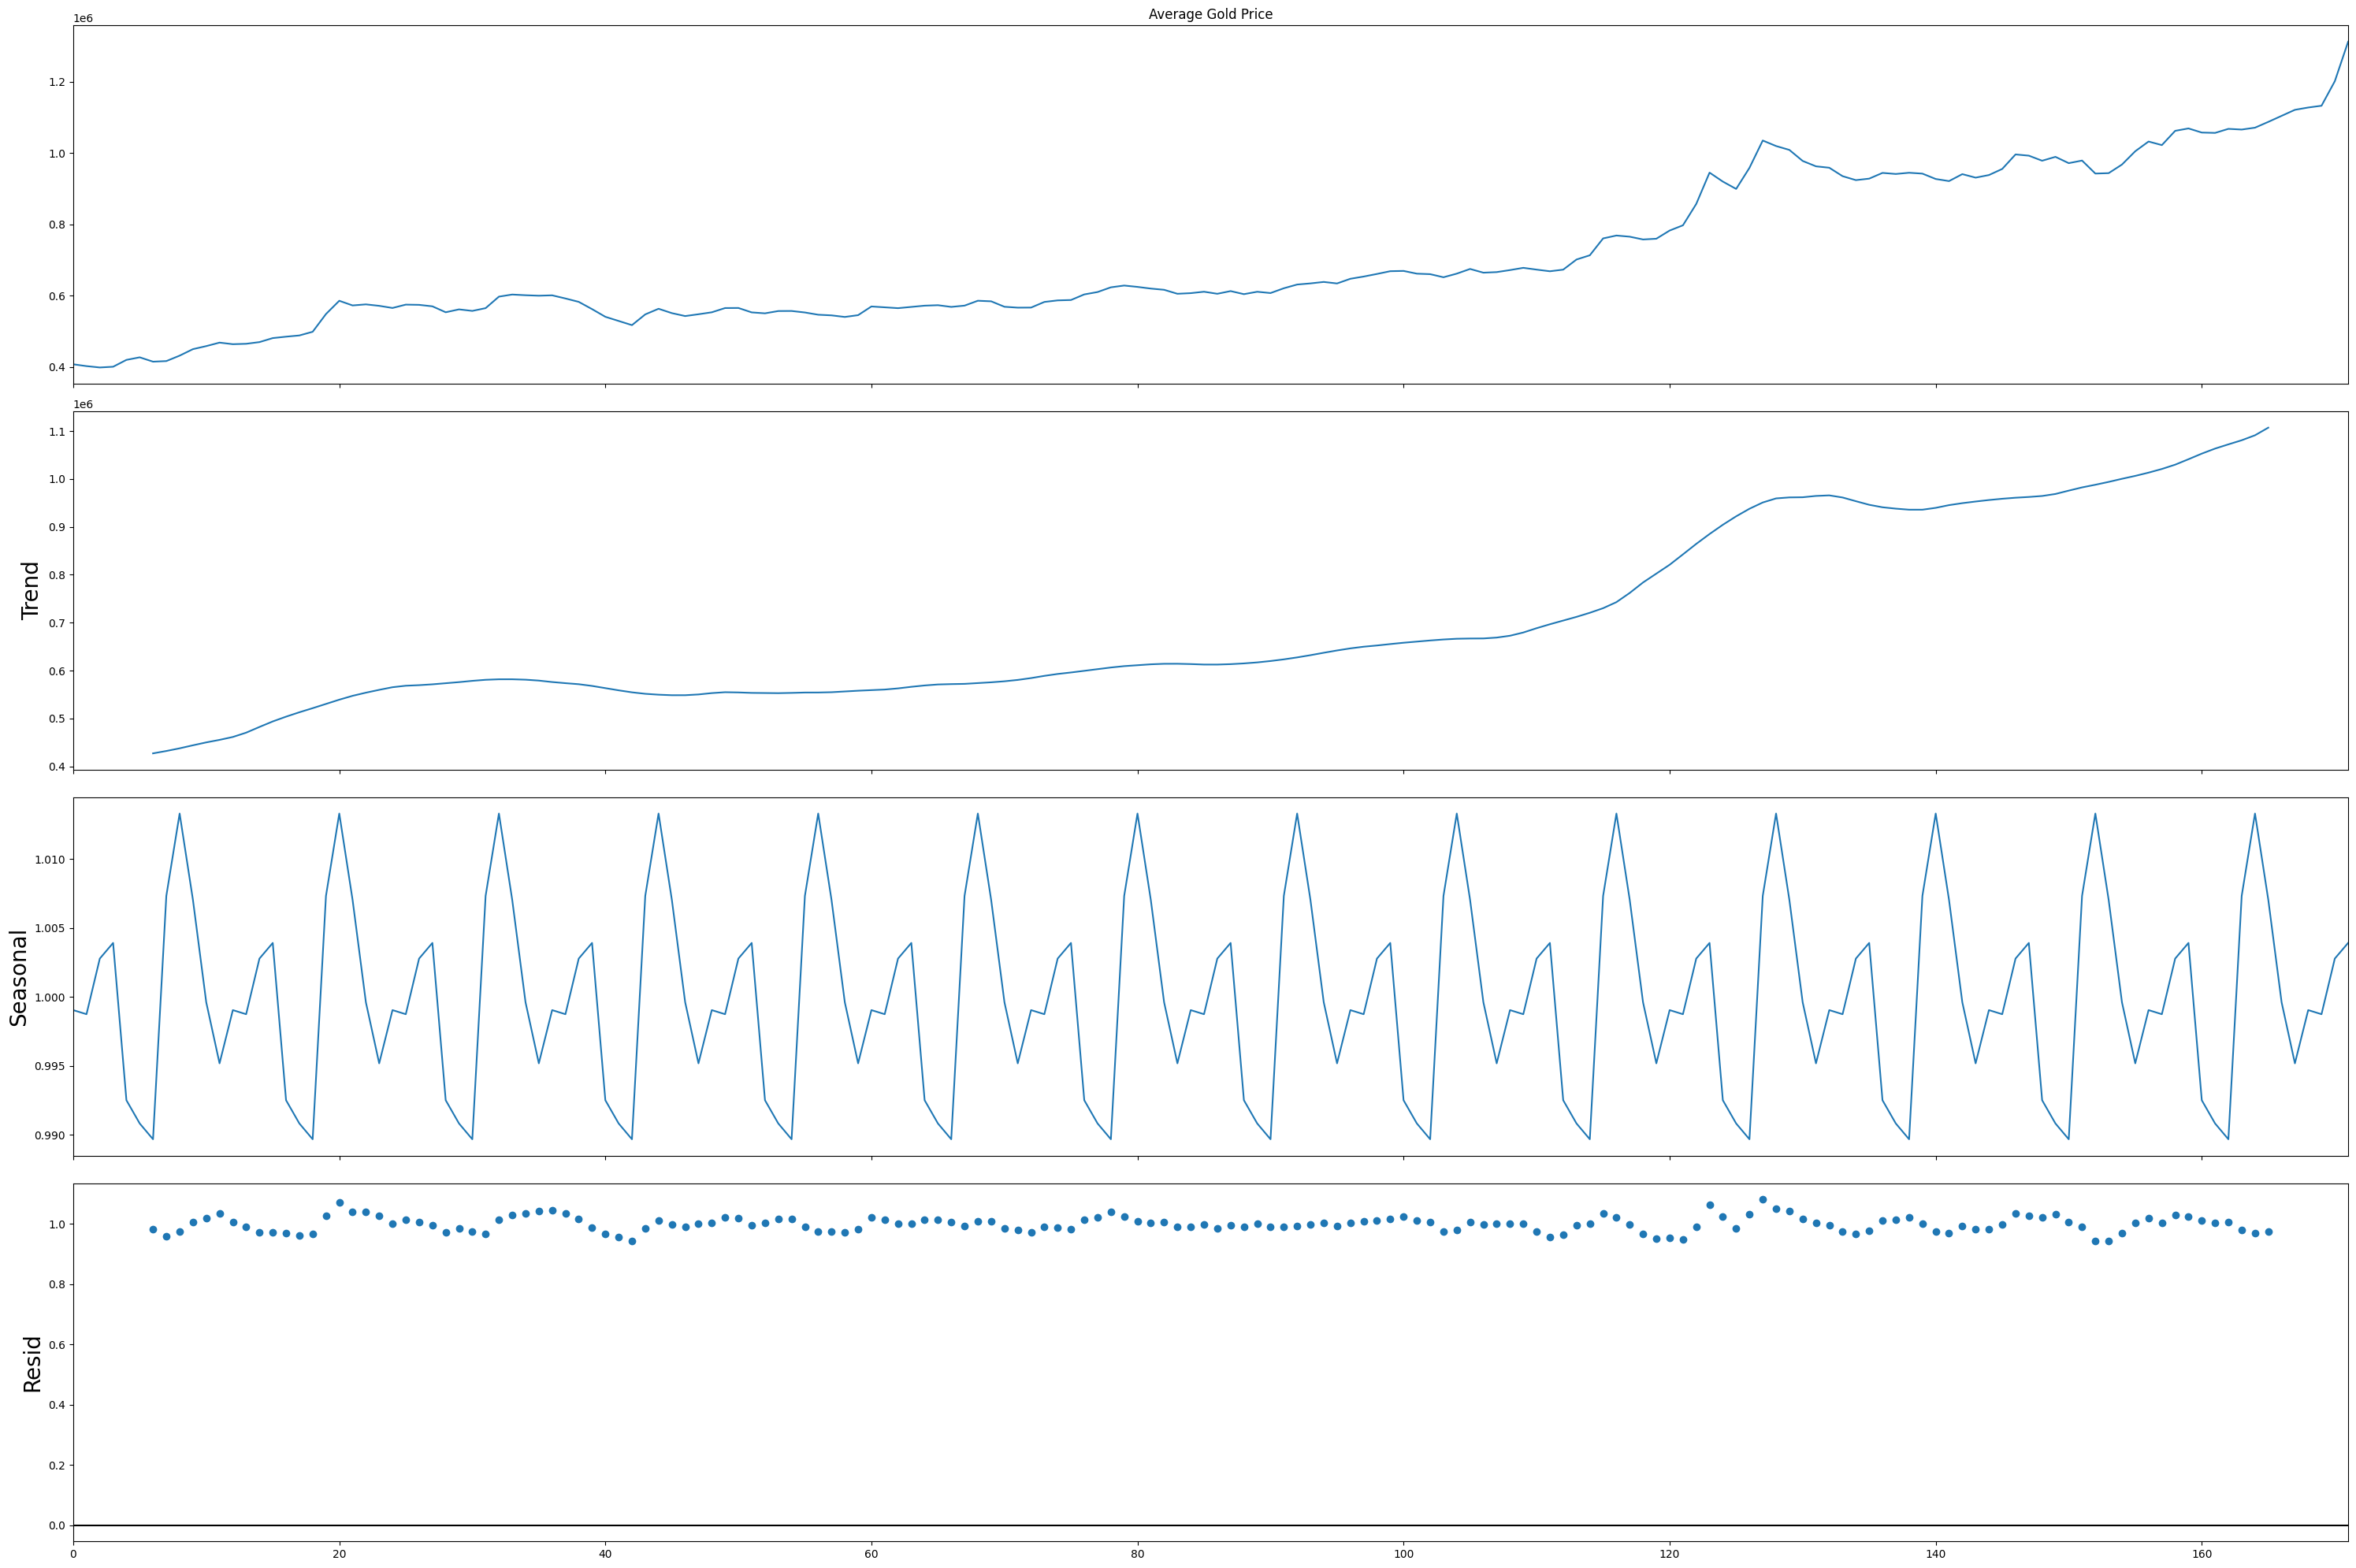

In [13]:
#Decompose
decomposition = seasonal_decompose(monthly['Average Gold Price'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

In [14]:
# lets create time series from goldprice 
timeSeries = monthly.loc[:, ["Year-Month","Average Gold Price"]]
timeSeries.index = timeSeries['Year-Month']
ts = timeSeries.drop("Year-Month",axis=1)
ts.tail()

,Average Gold Price
Year-Month,
2023-12-31,1.121345e+06
2024-01-31,1.127833e+06
2024-02-29,1.132793e+06
2024-03-31,1.201548e+06
2024-04-30,1.312214e+06


Stationarity Check

Detecting Unit Root: ADF & KPSS Test

In [15]:
adf_price_output = adfuller(ts)
kpss_price_output = kpss(ts)

pd.concat([
    unitroot_test_results(adf_price_output, 'adf'),
    unitroot_test_results(kpss_price_output, 'kpss')
], axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\3618356028.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,adf,kpss
Test Statistic,1.706545,1.648162
p-value,0.998144,0.01
Numbers of lags,2,9
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.469648,0.739
Critical Value (5%),-2.878799,0.463
Critical Value (10%),-2.575971,0.347
Critical Value (2.5%),NaN,0.574


Detecting Trend

In [16]:
kendall_tau_res = check_trend(ts, confidence=0.05)
mann_kendall_res = check_trend(ts, confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(ts, confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: True | Direction: increasing | Deterministic: False


Detrending & Deseasonalizing Techniques

AutoStationary

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\962537986.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\ASUS\Documents\GitHub\antam-gold-forecasting\tseries\transforms\target_transformations.py:545: UserWarning:

Trends with degree>1 are very strong and use with care.



Transformations applied: ['DetrendingTransformer']


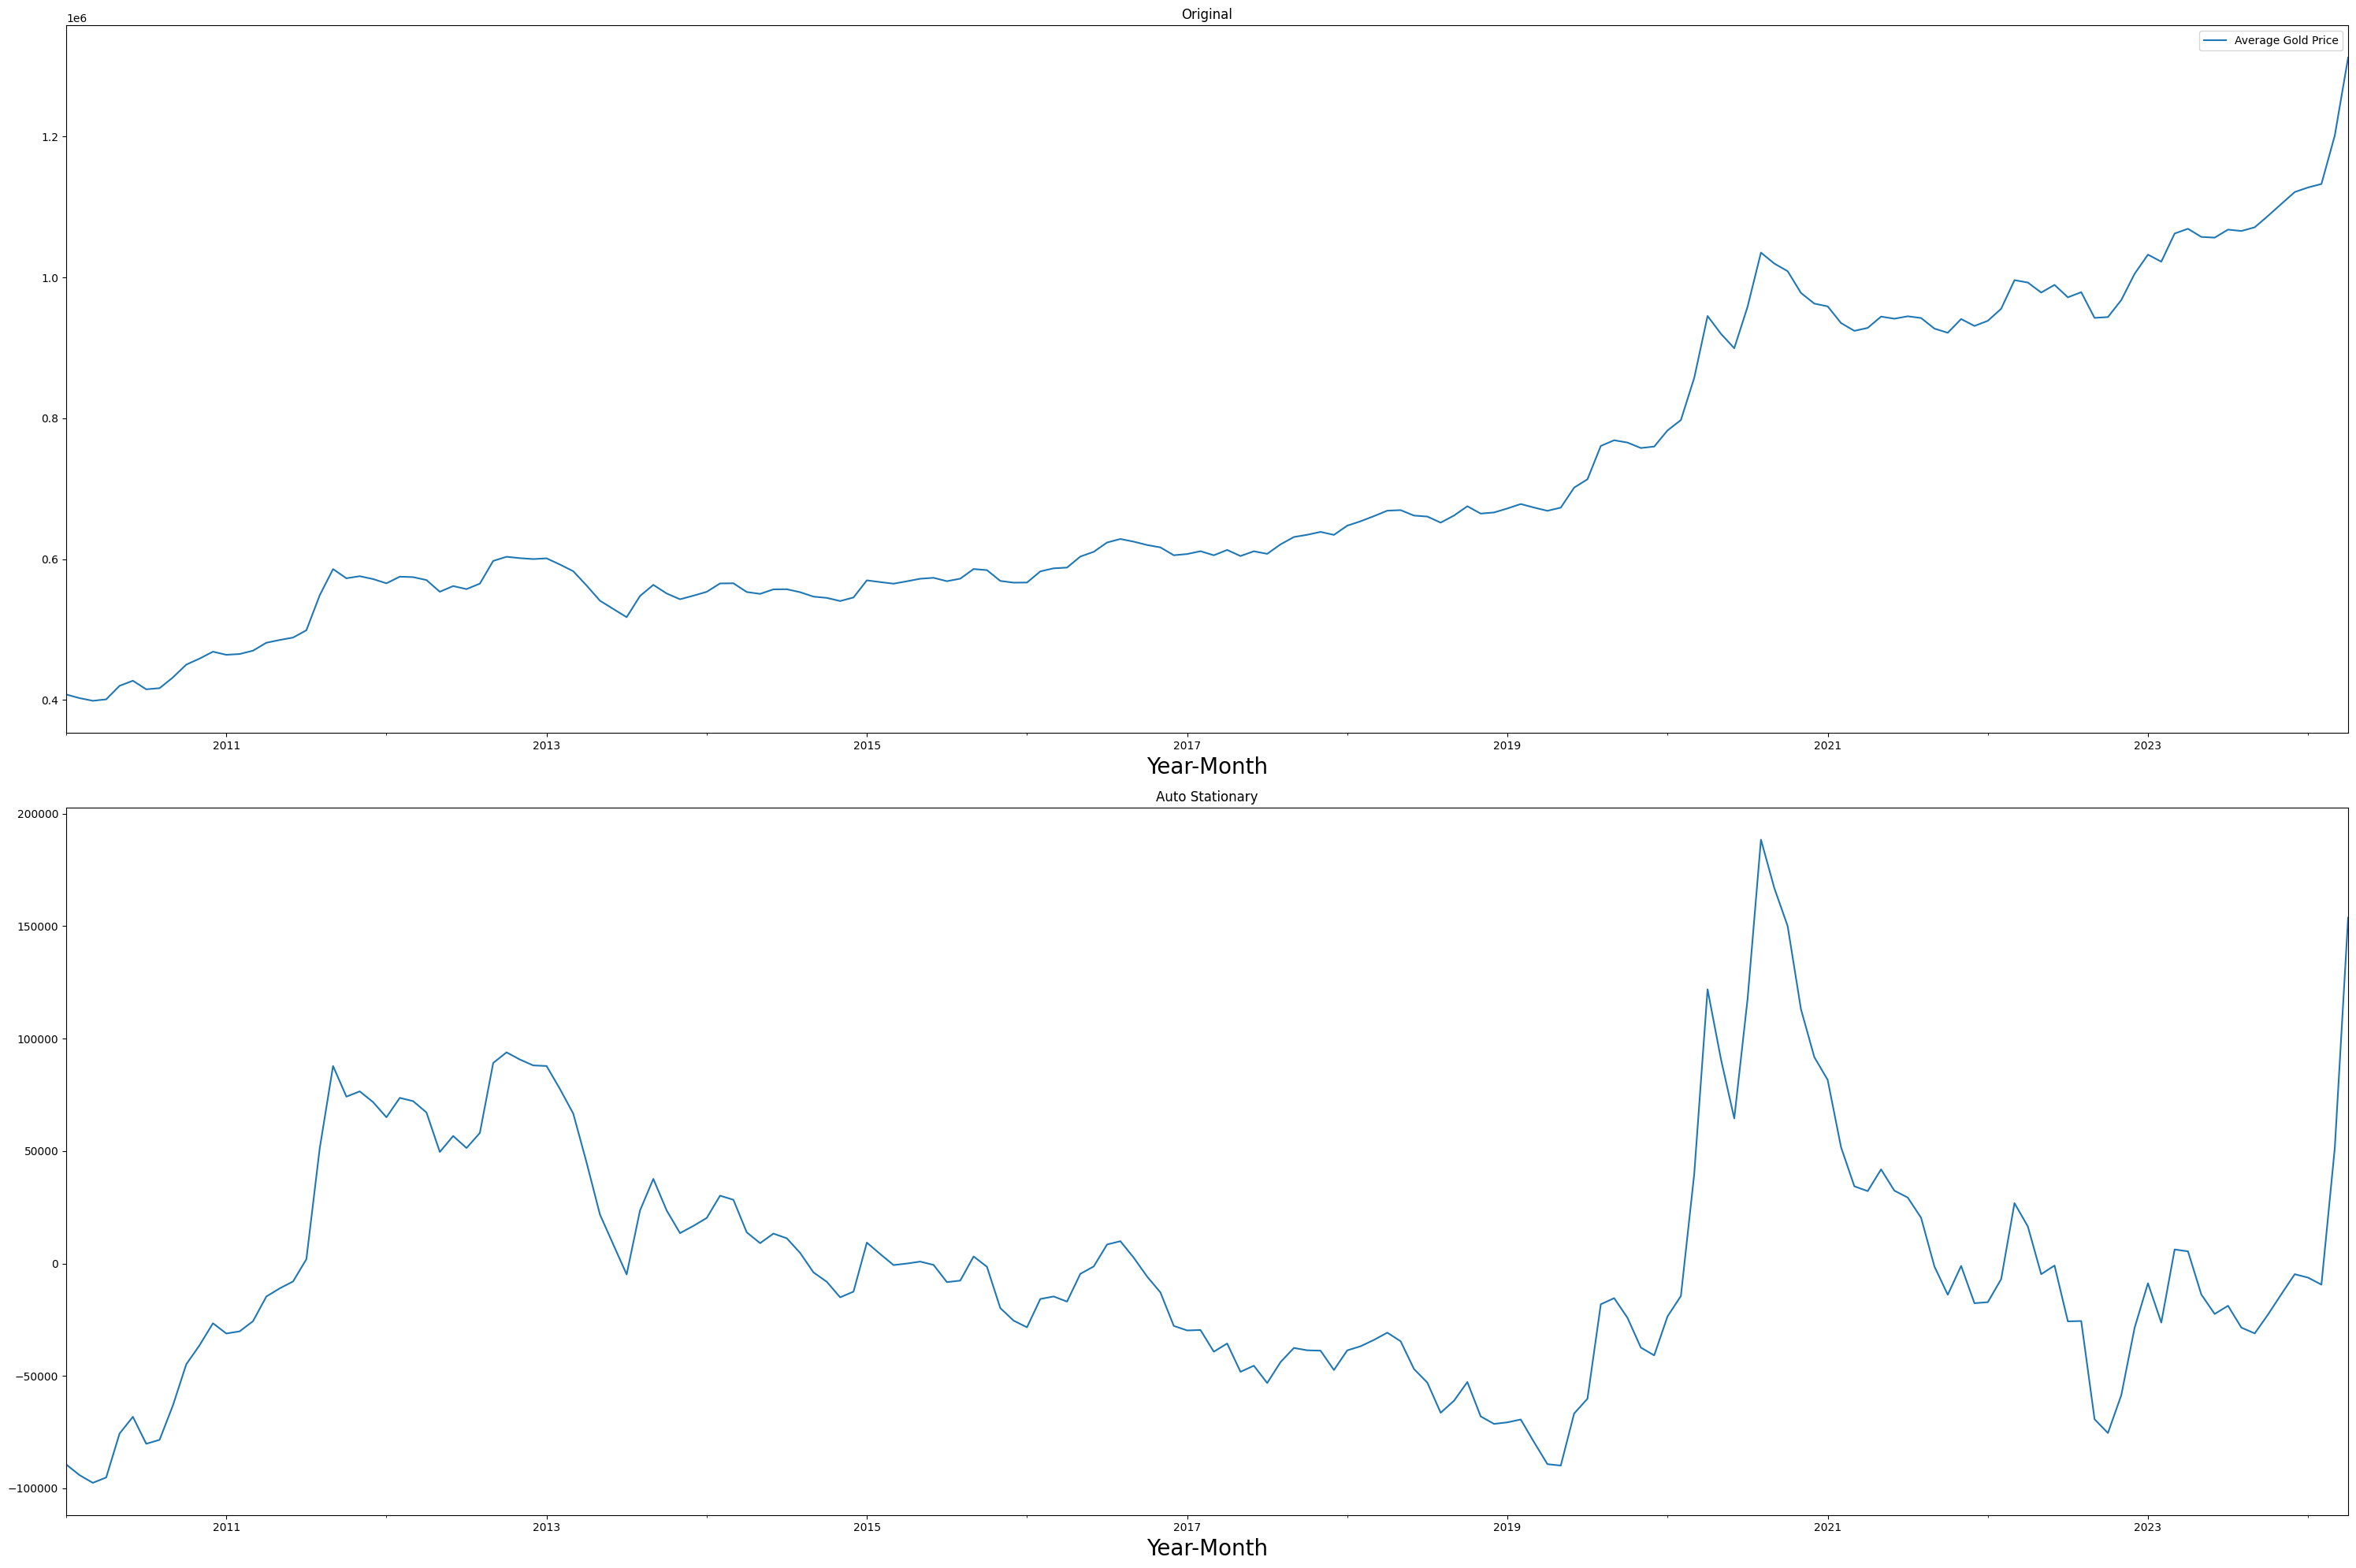

Unit Root: False with a p-value of 0.12102390098930671
Inverse == Original @ precision of 2 decimal points: True


In [17]:
ts.index.freq = 'M'
auto_stationary = AutoStationaryTransformer(seasonal_period=12, 
                                            detrender_params={'degree':2}, 
                                            trend_check_params={"mann_kendall":True})
y_stat = auto_stationary.fit_transform(ts, )
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

ts.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.05)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), index=ts.index, columns=["Average Gold Price"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==ts.round(3))}")

Other Techniques

Optimal Lambda: -0.6837679306030632


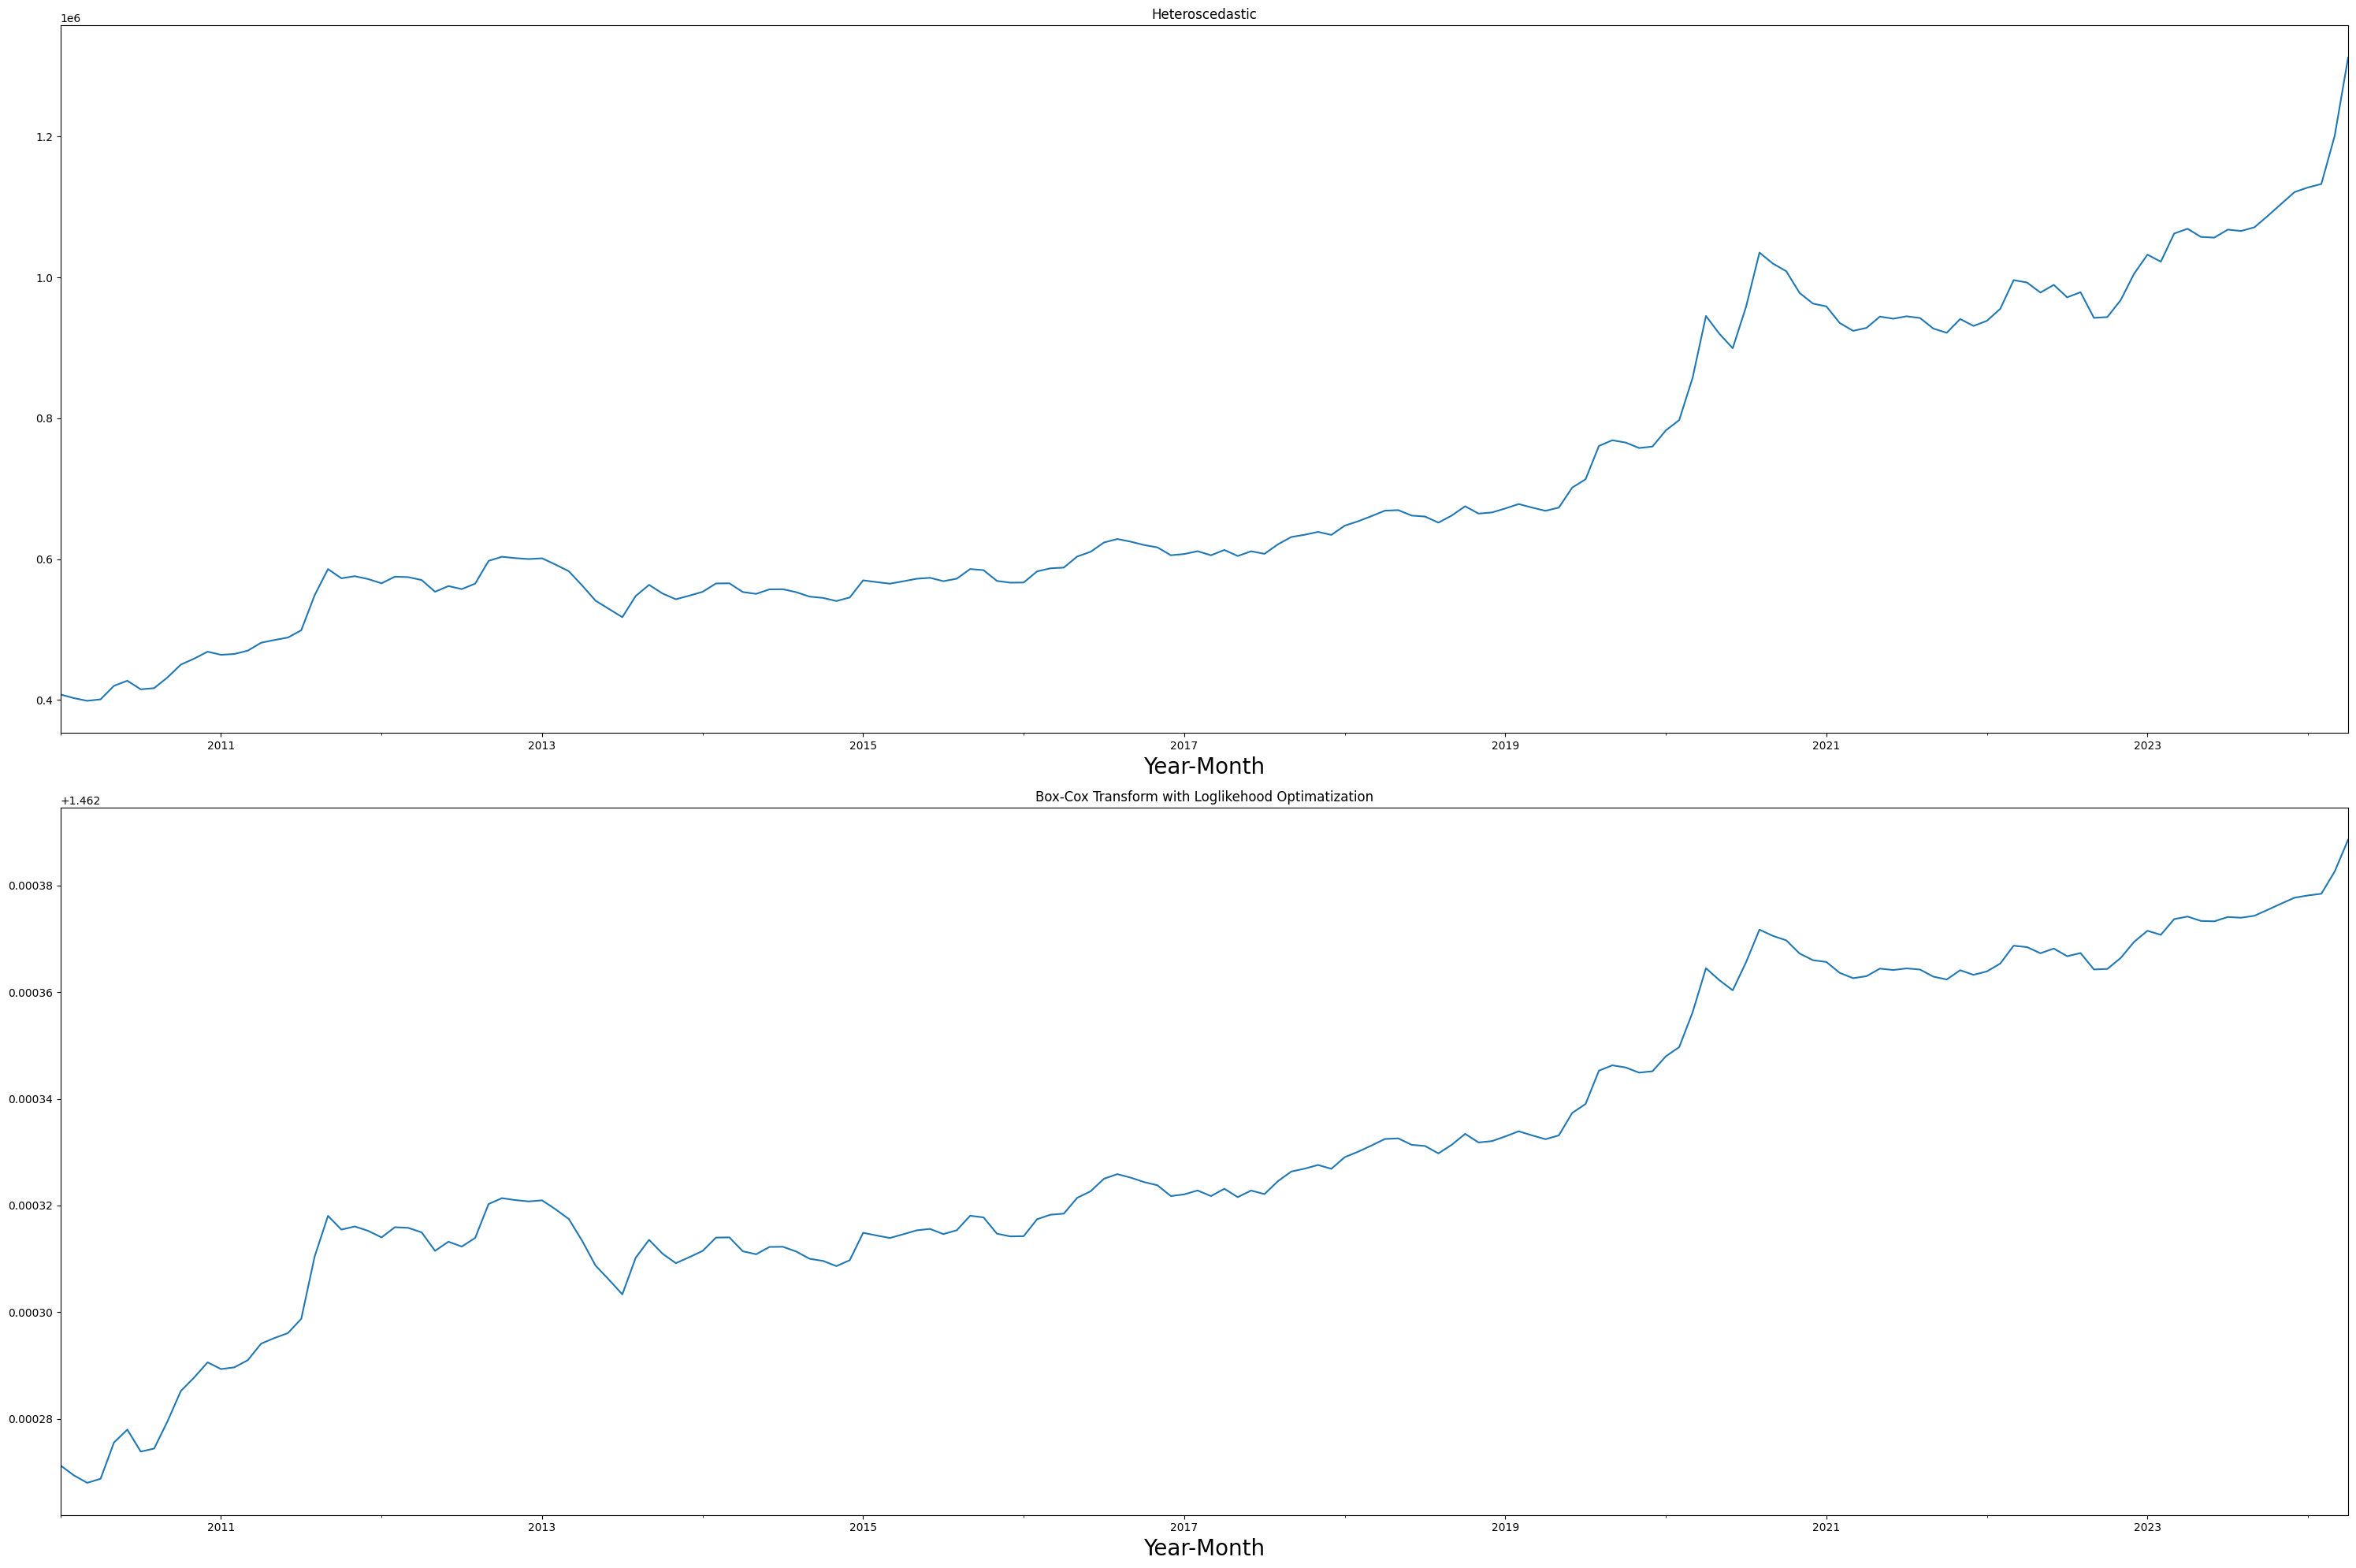

White Test for Heteroscedasticity: True with a p-value of 3.5677090703277625e-07


In [18]:
#shifting the series into positive domain
boxcox_transformer = BoxCoxTransformer(add_one=True, optimization="loglikelihood")
y_boxcox_loglikelihood = boxcox_transformer.fit_transform(ts["Average Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")

fig, axs = plt.subplots(2)
ts["Average Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_loglikelihood.plot(title="Box-Cox Transform with Loglikehood Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()

hetero_res = check_heteroscedastisticity(y_boxcox_loglikelihood, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

Optimal Lambda: -0.3185242875862059


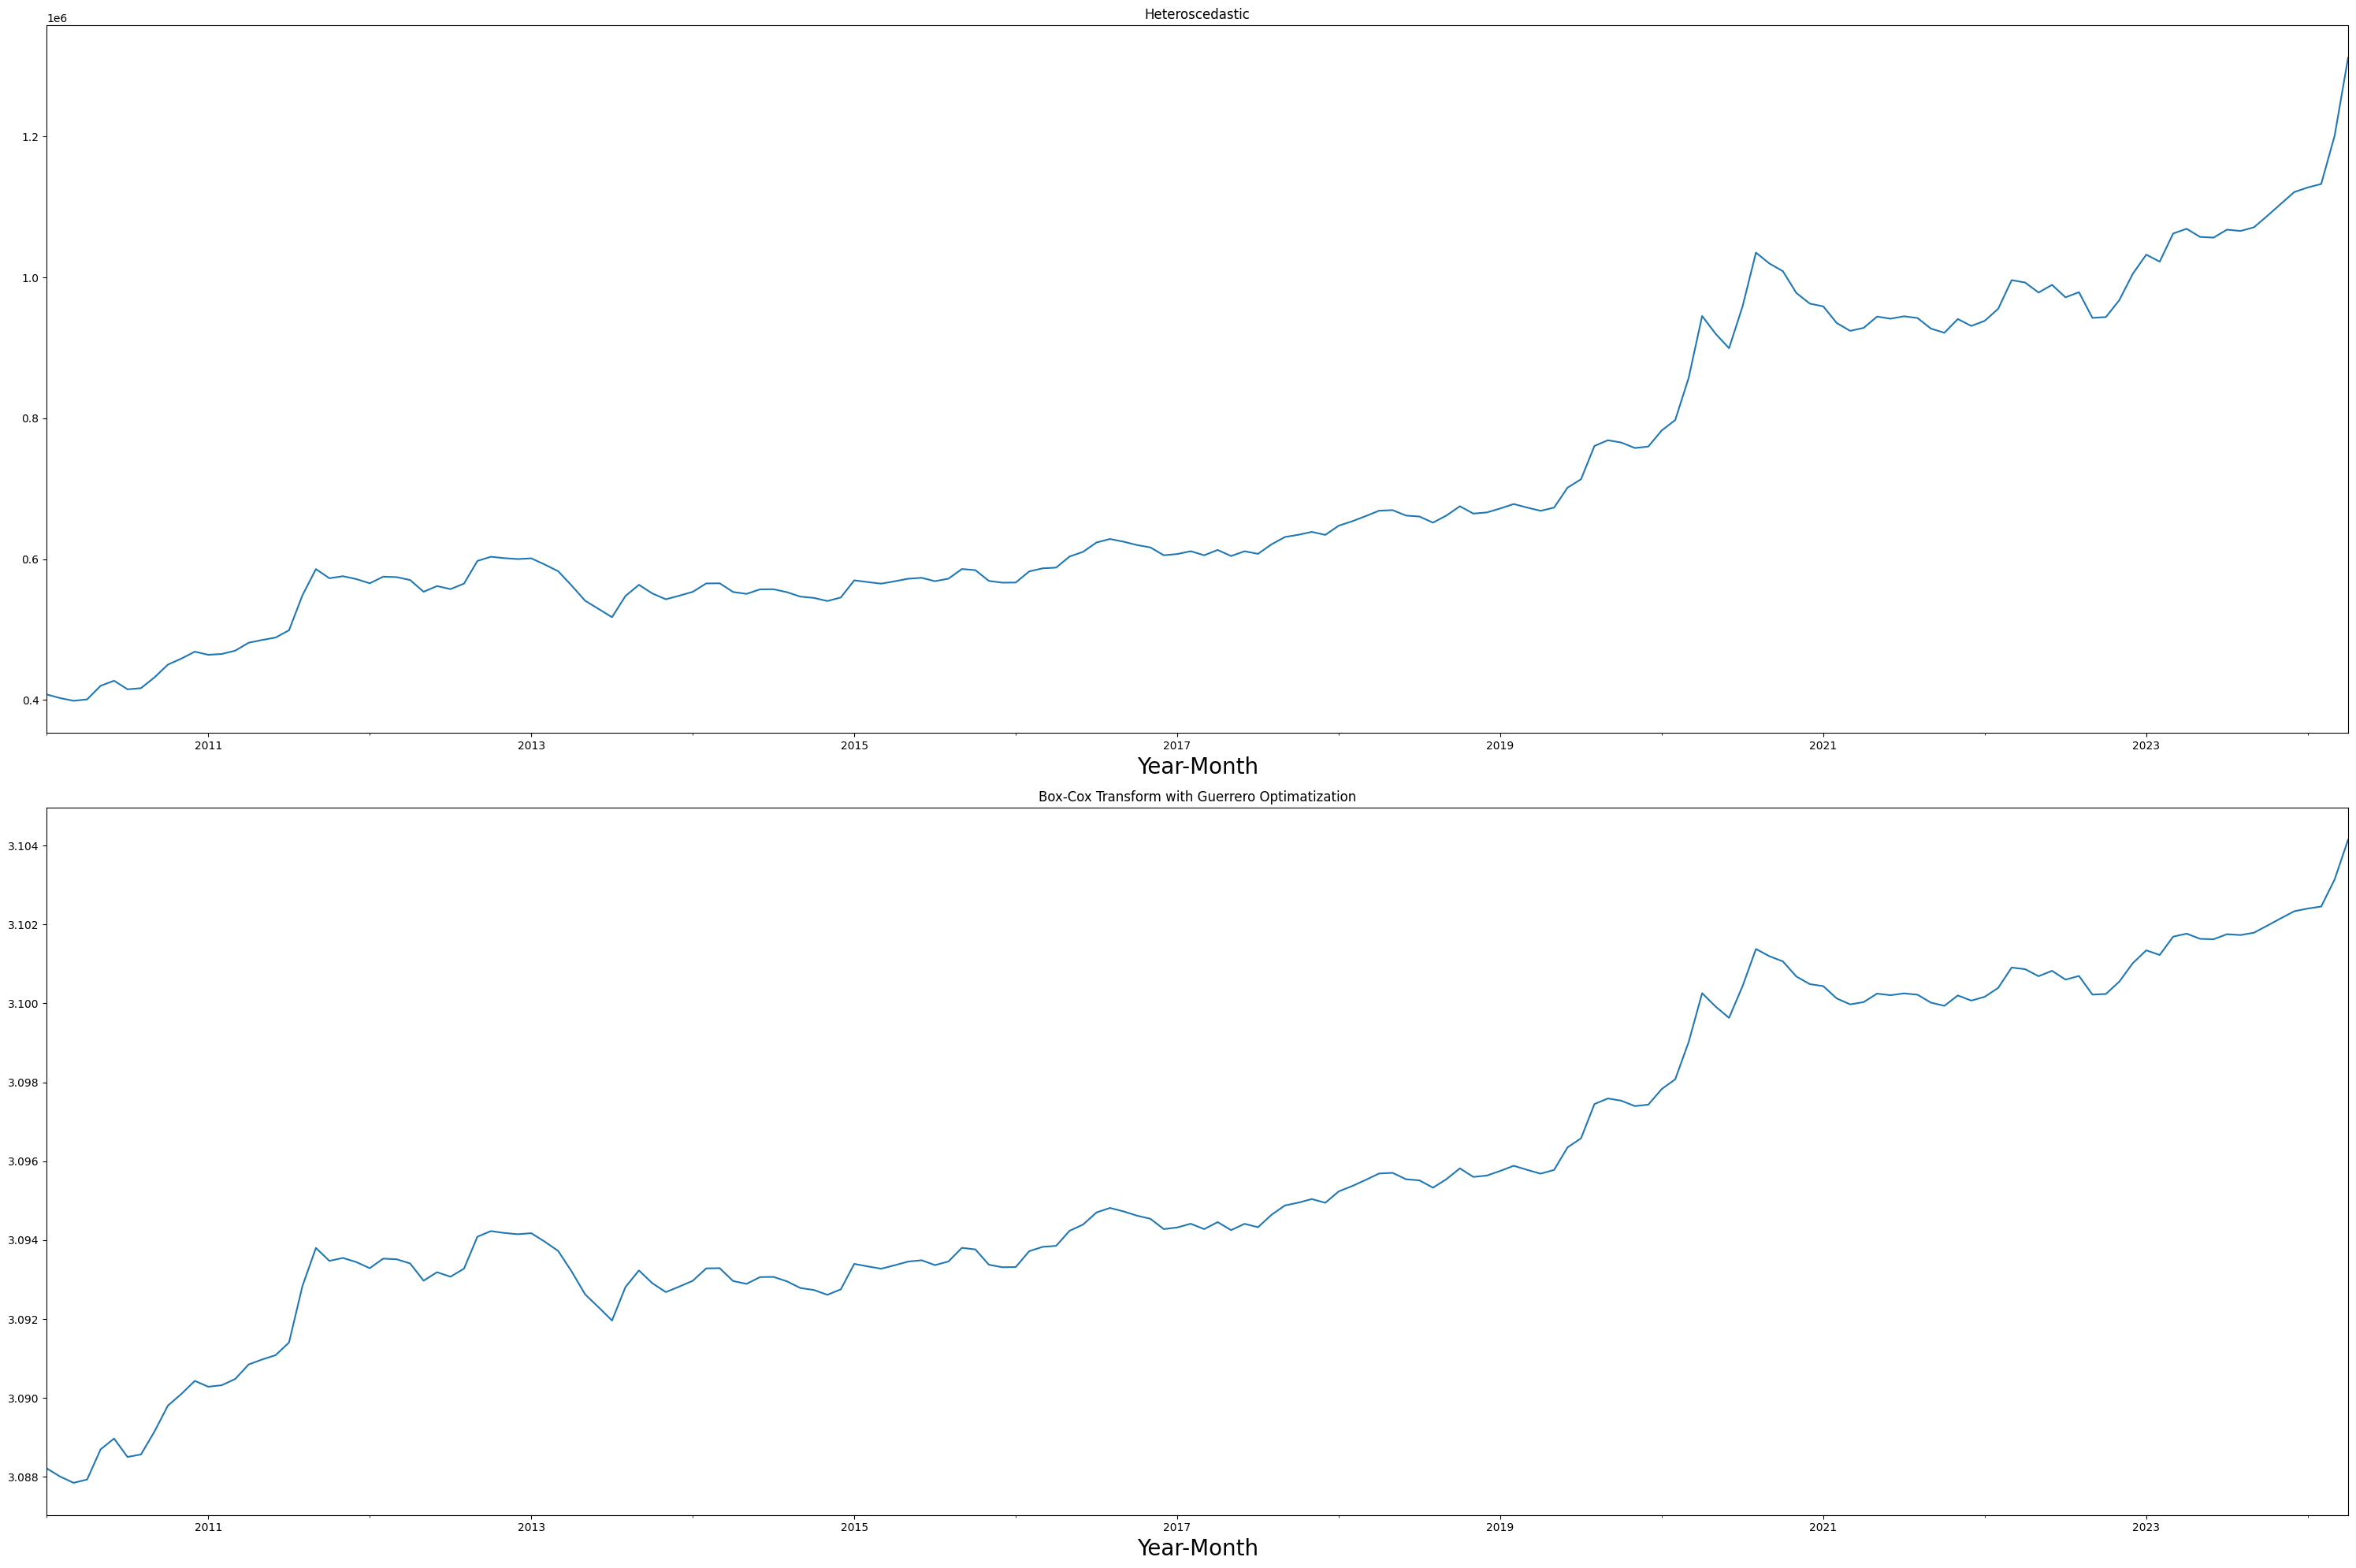

White Test for Heteroscedasticity: True with a p-value of 0.00592265782051293


In [19]:
#Arbritarily divided the data into sub-series of length 12
boxcox_transformer = BoxCoxTransformer(seasonal_period=12, add_one=True, optimization="guerrero")
y_boxcox_guerrero = boxcox_transformer.fit_transform(ts["Average Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
ts["Average Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_guerrero.plot(title="Box-Cox Transform with Guerrero Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox_guerrero, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\1990236185.

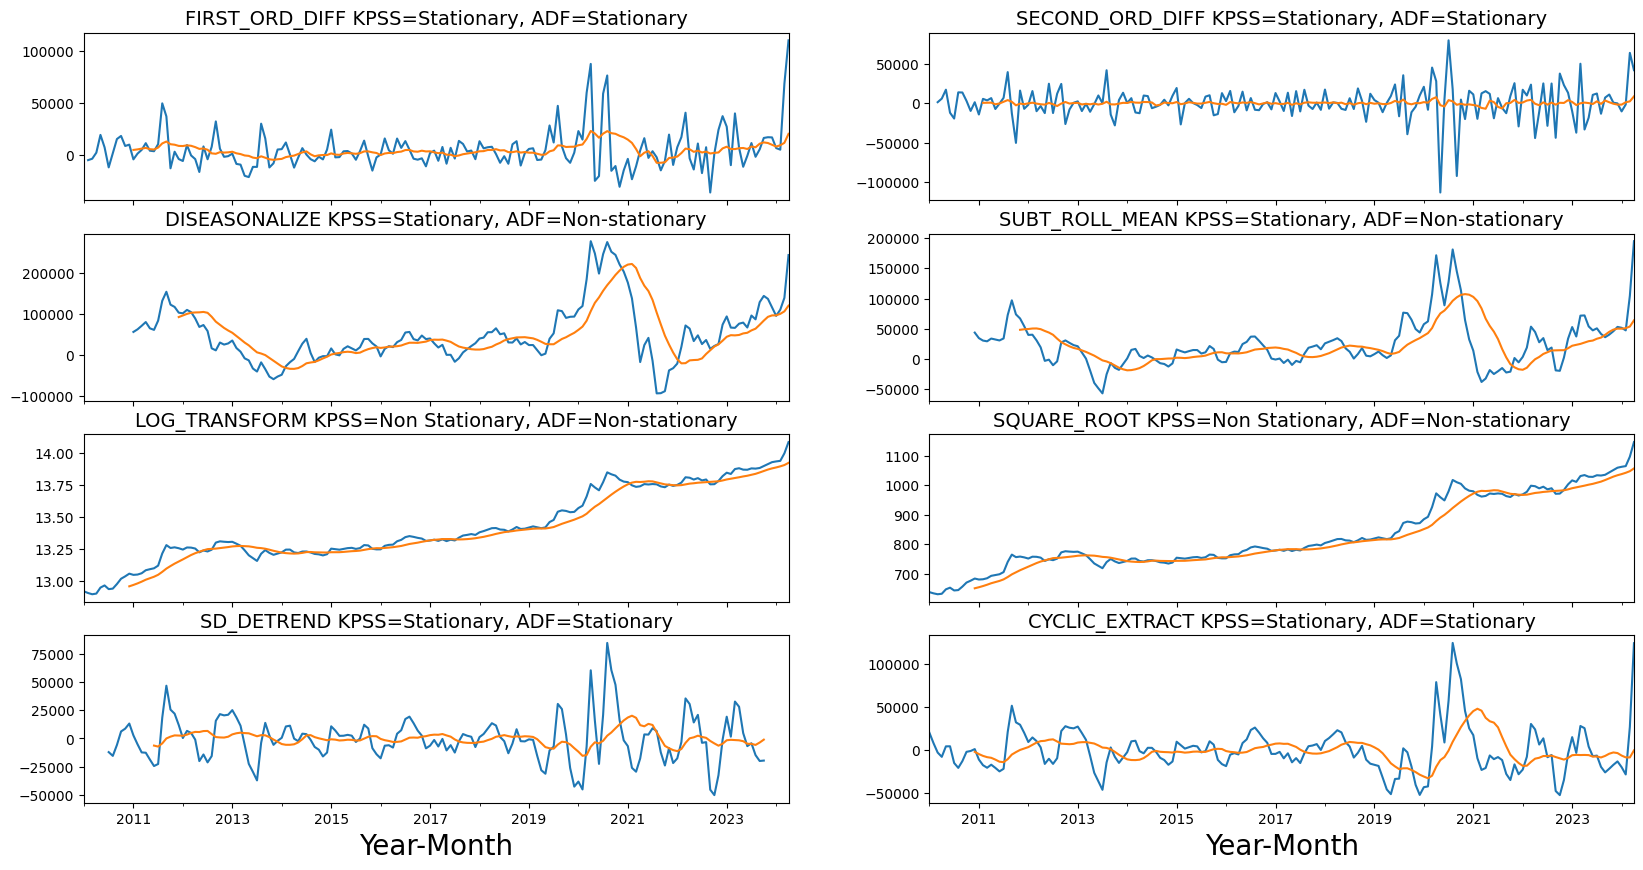

In [20]:
# using first order differencing (detrending)
first_ord_diff = ts.diff().dropna()

# using second order differencing
second_ord_diff = ts.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = ts.diff(12).dropna()

# using rolling mean 
rolling_mean = ts.rolling(window=12).mean()
subt_roll_mean = ts - rolling_mean

# log transform
log_transform = np.log(ts)

# Square root transform
square_root = np.sqrt(ts)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(ts)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(ts)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

plot = plot_comparison(methods)

Detecting Seasonality

Plotting ACF & PACF

Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


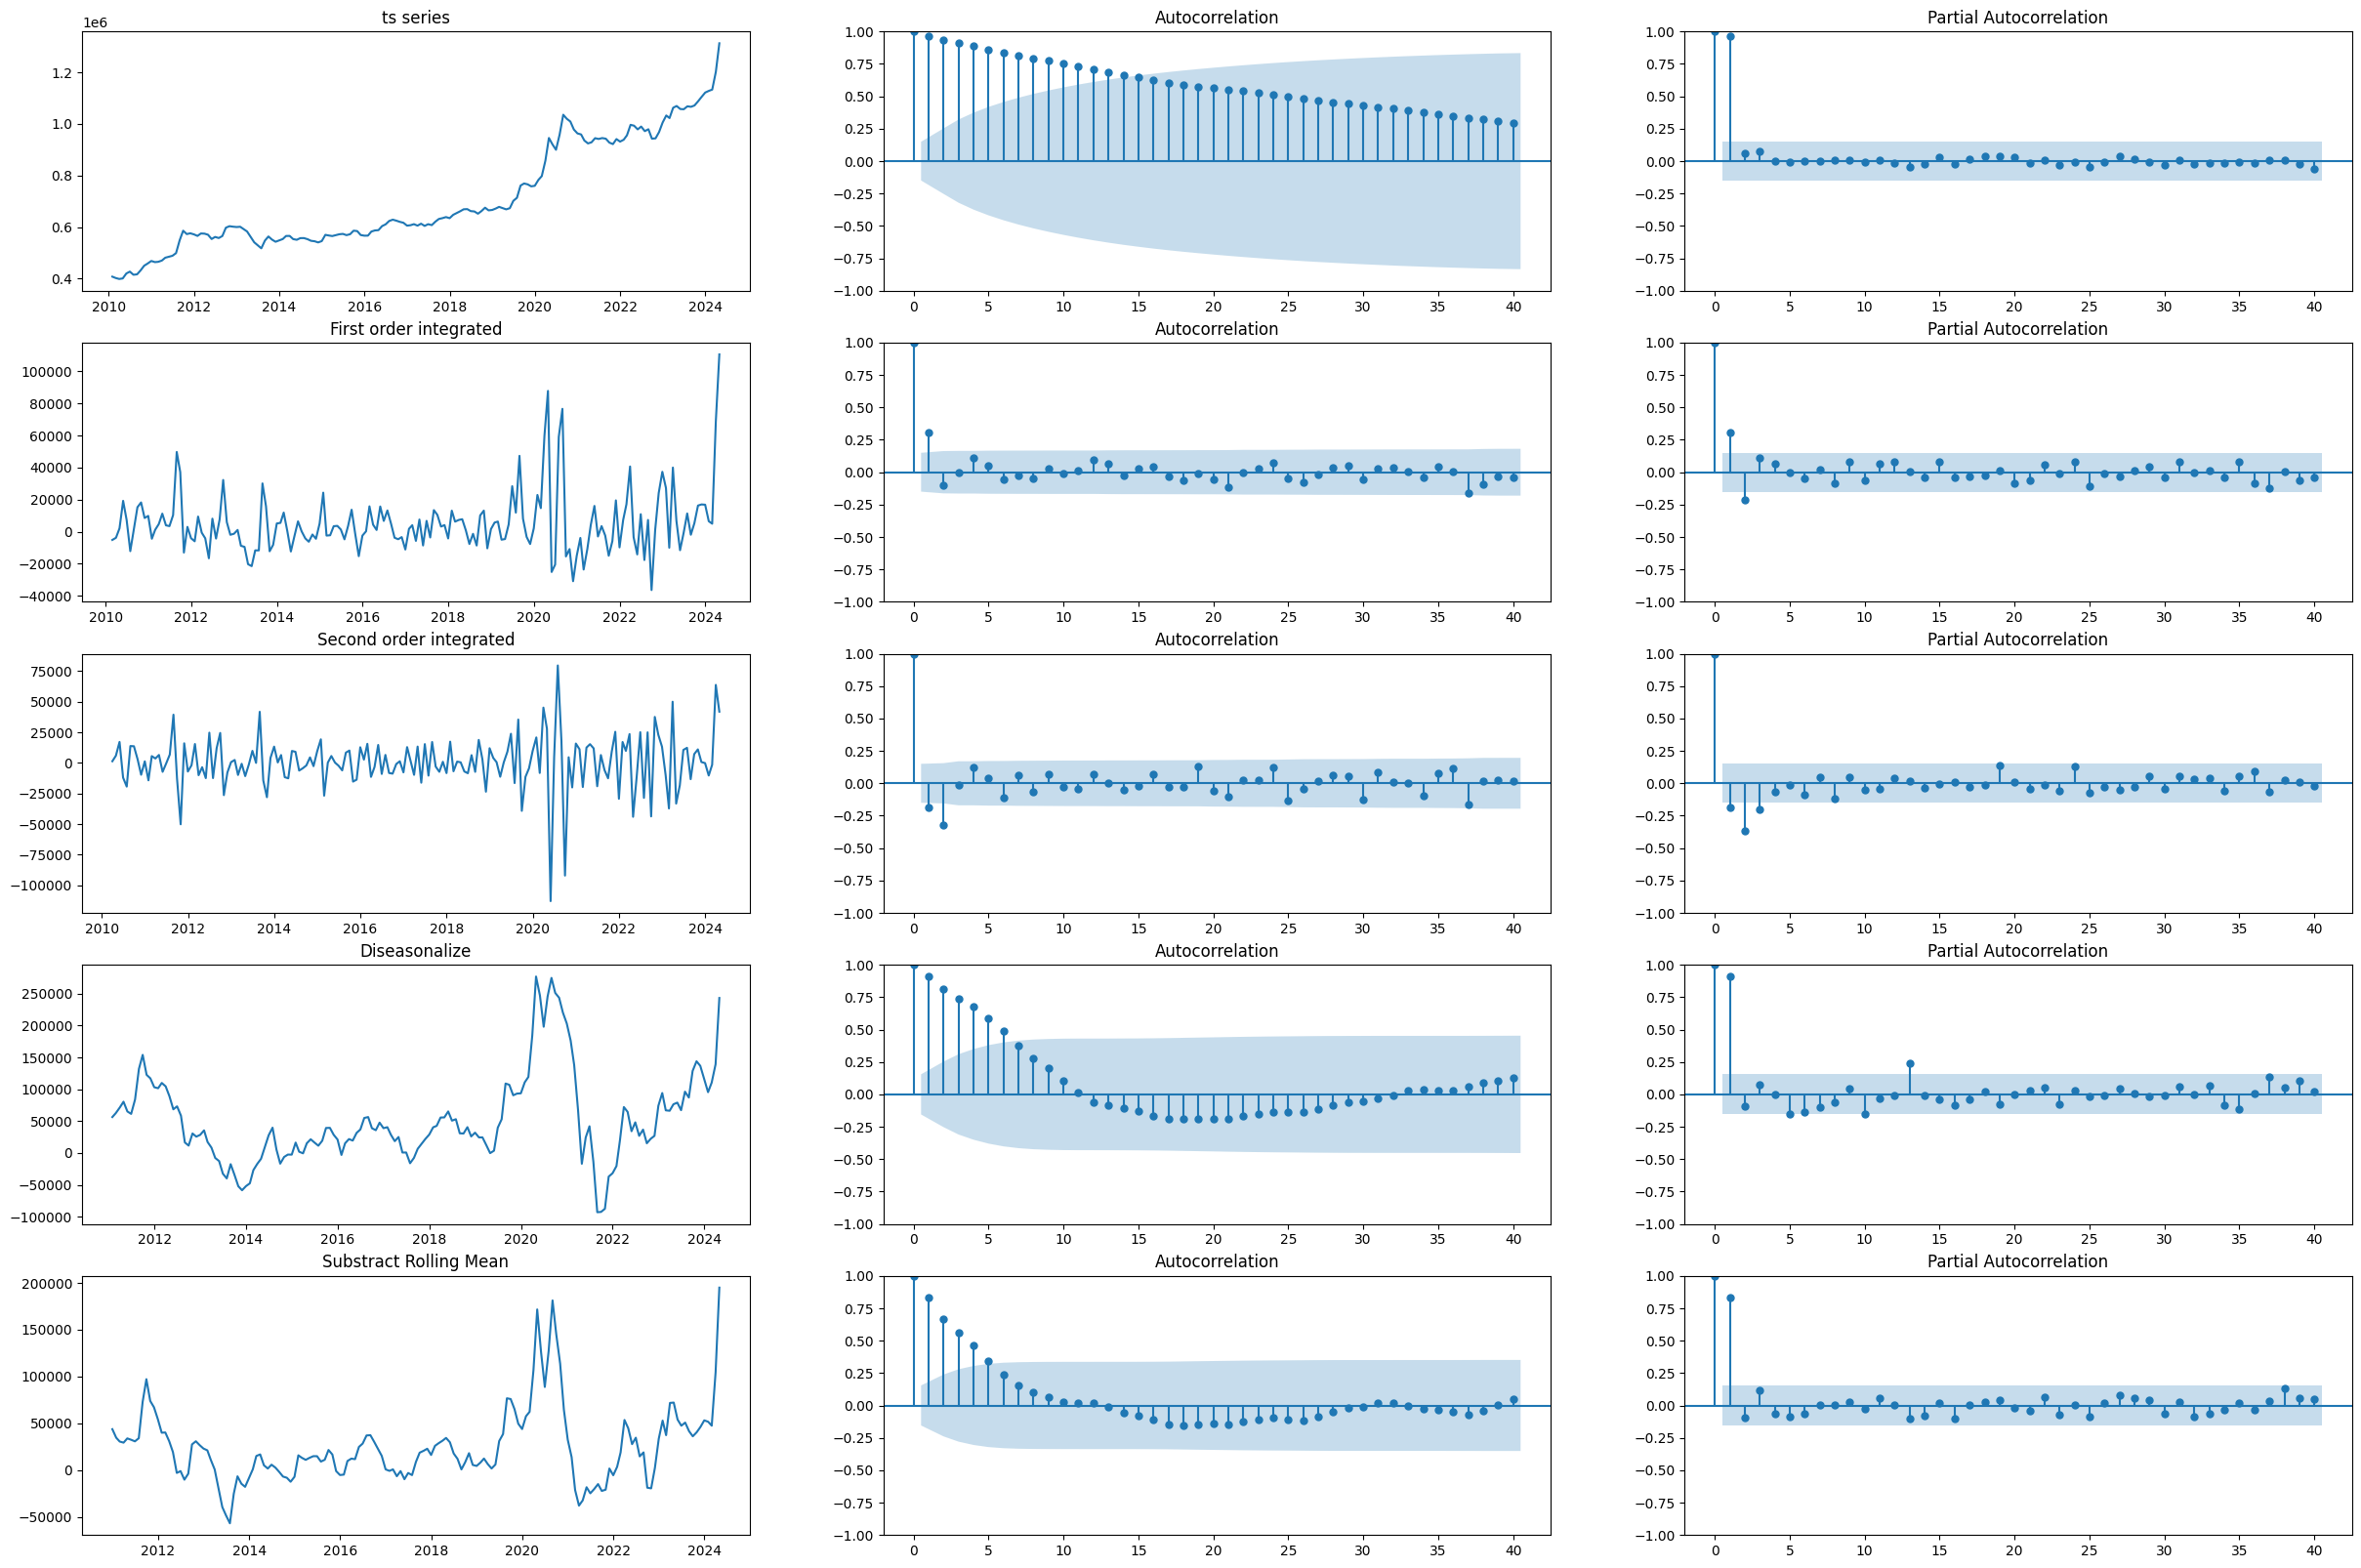

In [21]:
fig, axes = plt.subplots(5, 3, figsize=(30, 20))

# plot original series
axes[0,0].plot(ts)
axes[0,0].set_title("ts series")
print(plot_acf(ts, ax=axes[0,1], lags=40))
print(plot_pacf(ts, ax=axes[0,2], lags=40))

# plot first order integrated series
axes[1,0].plot(first_ord_diff)
axes[1,0].set_title("First order integrated")
print(plot_acf(first_ord_diff, ax=axes[1,1], lags=40))
print(plot_pacf(first_ord_diff, ax=axes[1,2], lags=40))

# plot first order integrated series
axes[2,0].plot(second_ord_diff)
axes[2,0].set_title("Second order integrated")
print(plot_acf(second_ord_diff, ax=axes[2,1], lags=40))
print(plot_pacf(second_ord_diff, ax=axes[2,2], lags=40))

# Deseasonalize series
axes[3,0].plot(diseasonalize)
axes[3,0].set_title("Diseasonalize")
print(plot_acf(diseasonalize, ax=axes[3,1], lags=40))
print(plot_pacf(diseasonalize, ax=axes[3,2], lags=40))

# Subtract Rolling Mean series
axes[4,0].plot(subt_roll_mean)
axes[4,0].set_title("Substract Rolling Mean")
print(plot_acf(subt_roll_mean, ax=axes[4,1], lags=40))
print(plot_pacf(subt_roll_mean, ax=axes[4,2], lags=40))

## Checking Stationarity

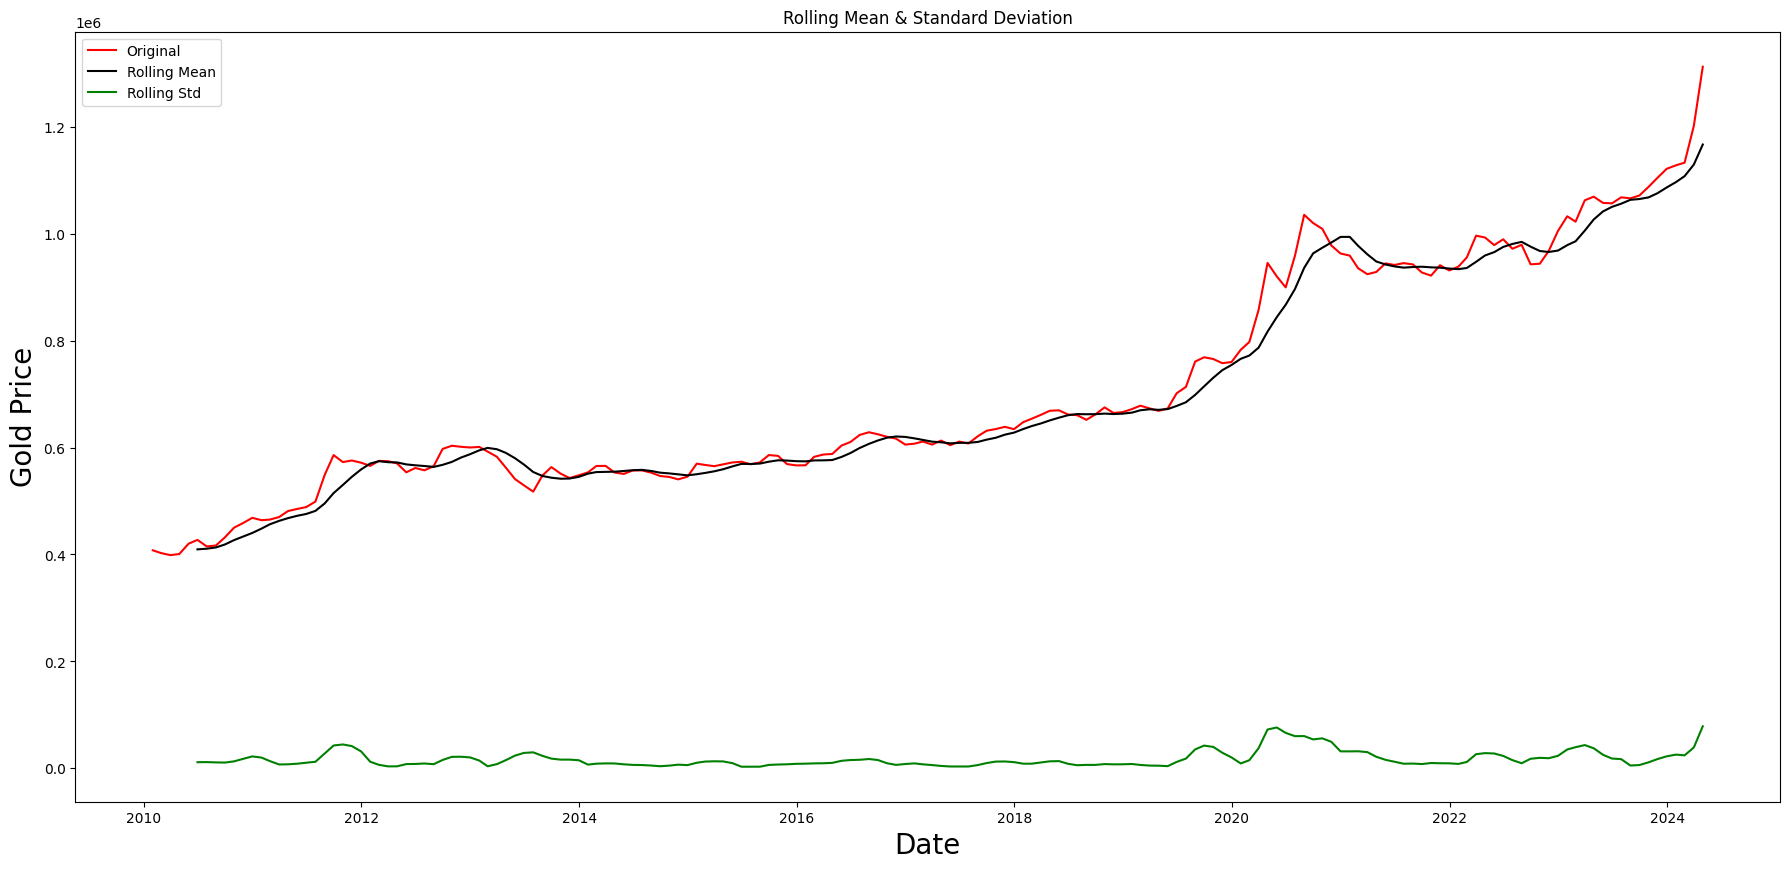

Test statistic:  1.7065450722041118
p-value:  0.9981444789835767
Critical Values: {'1%': -3.469648263987657, '5%': -2.878798906308495, '10%': -2.5759713094779593}


In [22]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    # Rolling statistics
    rolmean = ts.rolling(window=6).mean()
    rolstd = ts.rolling(window=6).std()
    
    # Plotting
    plt.figure(figsize=(22, 10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Gold Price")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

# check stationary: mean, variance(std), and adfuller test
check_mean_std(ts)
check_adfuller(ts)


Our initial criterion for stationarity is a _constant mean_. However, our data fails this criterion as depicted by the non-constant mean evident from the plot (shown by the black line). Consequently, our data is deemed non-stationary.

The second criterion concerns constant variance, which appears to be satisfied in our case. Hence, our data meets this condition for stationarity.

Lastly, if the test statistic is lower than the critical value, we can conclude that the time series is stationary. Upon examination, we find that the test statistic is 1.2, whereas the critical values are as follows: {'1%', '5%', '10%'}. Since the test statistic exceeds the critical values, our time series is not stationary.

In summary, based on the above analyses, it is evident that our time series data is not stationary. Consequently, in the subsequent section, we will explore methods to transform the time series into a stationary form.

Detecting Statistically

In [23]:
def get_var_name(variable):
     for name, value in globals().items():
        if value is variable:
            return name
        
method_names = [get_var_name(method) for method in methods]

In [24]:
for method, method_name in zip(methods, method_names):
    seasonality_res = check_seasonality(method, max_lag=24, seasonal_period=12, confidence=0.05)
    print(f"Seasonality Test for 12th lag using {method_name}: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using first_ord_diff: True
Seasonality Test for 12th lag using second_ord_diff: True
Seasonality Test for 12th lag using diseasonalize: False
Seasonality Test for 12th lag using subt_roll_mean: False
The ACF has no local maximum for m < max_lag = 24. Try larger max_lag
Seasonality Test for 12th lag using log_transform: False
The ACF has no local maximum for m < max_lag = 24. Try larger max_lag
Seasonality Test for 12th lag using square_root: False
Seasonality Test for 12th lag using sd_detrend: True
Seasonality Test for 12th lag using cyclic_extract: False


Checking Normality

In [25]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [26]:
normal_args = (np.mean(ts),np.std(ts))

print(is_normal(shapiro(ts)))
print(is_normal(normaltest(ts)))
print(is_normal(normal_ad(ts)))
print(is_normal(kstest_normal(ts)))

Not Normal
Not Normal
Not Normal
Not Normal


c:\Users\ASUS\.pyenv-win-venv\envs\antam_forecast_env\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



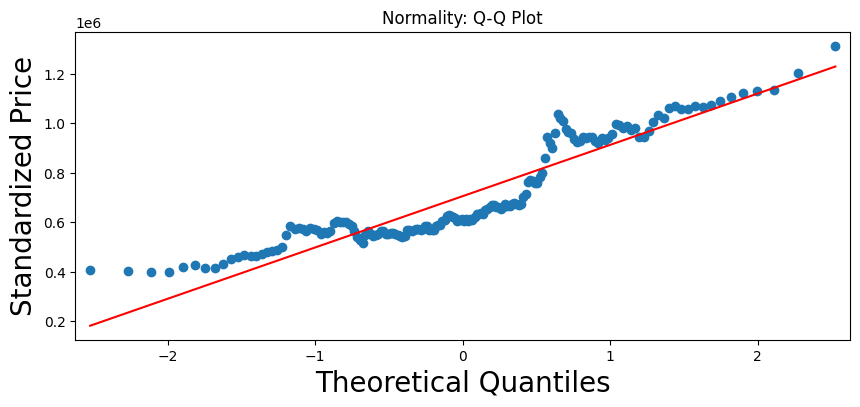

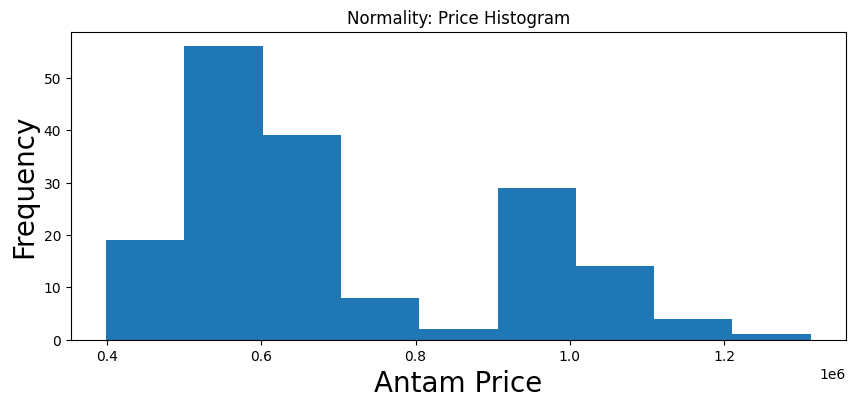

In [27]:
plt.rcParams["figure.figsize"] = [10, 4]

sm.qqplot(ts, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Price')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(ts, bins='auto')
plt.xlabel('Antam Price')
plt.ylabel('Frequency')
plt.title('Normality: Price Histogram')
plt.show()

Heteroskedactisity Test

In [28]:
for method, method_name in zip(methods, method_names):
    hetero_white_res = check_heteroscedastisticity(method, confidence=0.05)
    print(f"White Test for Heteroscedasticity on {method_name}: {hetero_white_res.heteroscedastic} with a p-value of {hetero_white_res.lm_p_value}")

White Test for Heteroscedasticity on first_ord_diff: True with a p-value of 0.0010362801953888807
White Test for Heteroscedasticity on second_ord_diff: True with a p-value of 0.029985984586903564
White Test for Heteroscedasticity on diseasonalize: True with a p-value of 0.04926410149787562
White Test for Heteroscedasticity on subt_roll_mean: True with a p-value of 0.028049431046420912
White Test for Heteroscedasticity on log_transform: False with a p-value of 0.19705975586561233
White Test for Heteroscedasticity on square_root: False with a p-value of 0.1593781797504534
White Test for Heteroscedasticity on sd_detrend: True with a p-value of 0.018627821743076454
White Test for Heteroscedasticity on cyclic_extract: True with a p-value of 0.006566341266501827
